<a href="https://colab.research.google.com/github/jdannem6/ML_Forex_Forecasting/blob/main/varima_eurgbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! git clone https://github.com/jdannem6/ML_Forex_Forecasting

Cloning into 'ML_Forex_Forecasting'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 306 (delta 106), reused 141 (delta 77), pack-reused 127
Receiving objects: 100% (306/306), 4.20 MiB | 6.79 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [27]:
import sys
sys.path.append('/ML_Forex_Forecasting')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Data Extraction #

In [28]:
eur_gbp = pd.read_csv("/content/ML_Forex_Forecasting/EURGBP=X.csv", parse_dates=['Date'])
eur_gbp = eur_gbp[['Date', 'Close', 'Open', 'High', 'Low']]
print(f"eur_gbp: {eur_gbp.shape}")
display(eur_gbp.head())

eur_gbp: (262, 5)


,Date,Close,Open,High,Low
0,2022-12-01,0.86302,0.86302,0.86409,0.85483
1,2022-12-02,0.85875,0.85875,0.86077,0.85563
2,2022-12-05,0.85737,0.85737,0.86311,0.85643
3,2022-12-06,0.86087,0.86087,0.86311,0.85821
4,2022-12-07,0.86260,0.86260,0.86427,0.86098


In [29]:
gold = pd.read_csv("/content/ML_Forex_Forecasting/GC=F.csv", parse_dates=['Date'])
gold = gold[['Date', 'Close']]
gold.rename(columns = {'Close' : 'Gold'}, inplace = True)

stoxx = pd.read_csv("/content/ML_Forex_Forecasting/STOXX50E.csv", parse_dates=['Date'])
stoxx = stoxx[['Date', 'Close']]
stoxx.rename(columns = {'Close' : 'Stoxx'}, inplace = True)

smi = pd.read_csv("/content/ML_Forex_Forecasting/FTSE.csv", parse_dates=['Date'])
smi = smi[['Date', 'Close']]
smi.rename(columns = {'Close' : 'FTSE'}, inplace = True)

print(f"Gold: {gold.shape}")
display(gold.head())
print(f"STOXX: {stoxx.shape}")
display(stoxx.head())
print(f"SMI: {smi.shape}")
display(smi.head())

Gold: (253, 2)


,Date,Gold
0,2022-12-01,1801.099976
1,2022-12-02,1795.900024
2,2022-12-05,1767.400024
3,2022-12-06,1769.300049
4,2022-12-07,1785.500000


STOXX: (254, 2)


,Date,Stoxx
0,2022-12-01,3984.500000
1,2022-12-02,3977.899902
2,2022-12-05,3956.530029
3,2022-12-06,3939.189941
4,2022-12-07,3920.899902


SMI: (253, 2)


,Date,FTSE
0,2022-12-01,7558.500000
1,2022-12-02,7556.200195
2,2022-12-05,7567.500000
3,2022-12-06,7521.399902
4,2022-12-07,7489.200195


In [31]:
df = eur_gbp.merge(gold[['Date', 'Gold']], on = 'Date', how = 'inner')
df = df.merge(stoxx[['Date', 'Stoxx']], on = 'Date', how = 'inner')
df = df.merge(smi[['Date', 'FTSE']], on = 'Date', how = 'inner')

df

,Date,Close,Open,High,Low,Gold,Stoxx,FTSE
0,2022-12-01,0.86302,0.86302,0.86409,0.85483,1801.099976,3984.500000,7558.500000
1,2022-12-02,0.85875,0.85875,0.86077,0.85563,1795.900024,3977.899902,7556.200195
2,2022-12-05,0.85737,0.85737,0.86311,0.85643,1767.400024,3956.530029,7567.500000
3,2022-12-06,0.86087,0.86087,0.86311,0.85821,1769.300049,3939.189941,7521.399902
4,2022-12-07,0.86260,0.86260,0.86427,0.86098,1785.500000,3920.899902,7489.200195
...,...,...,...,...,...,...,...,...
241,2023-11-27,0.86820,0.86820,0.86880,0.86580,2011.800049,4354.410156,7460.700195
242,2023-11-28,0.86731,0.86731,0.86830,0.86568,2039.699951,4348.020020,7455.200195
243,2023-11-29,0.86558,0.86558,0.86615,0.86420,2047.099976,4370.529785,7423.500000
244,2023-11-30,0.86429,0.86429,0.86488,0.86170,2038.099976,4382.470215,7453.799805


In [32]:
cols = df.columns[1:]

# Dickey fuller stationarity test #

In [33]:
def dickey_fuller_test(df,var, verbose = False):
    result = adfuller(df[var].values)
    #Extracting the values from the results:
    if verbose:

        print(f"Dickey-Fuller test for feature: {var}")

        print('Test Statistic: %f' % result[0])

        print('p-value: %f' % result[1])

        print('Critical Values:')

        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[0] < result[4]["5%"]:
            print ("Reject H0 - Time Series is Stationary")
        else:
            print ("Failed to Reject H0 - Time Series is Non-Stationary")

    if result[0] < result[4]["5%"]:
        return True

    return False

In [37]:
def test_stationarity(df, cols):
    res = {}
    for col in cols:
        if not dickey_fuller_test(df, col, verbose = False):
            res[col] = False
        else:
            res[col] = True
    return res

In [38]:
test_stationarity(df, cols)

{'Close': False,
 'Open': False,
 'High': False,
 'Low': False,
 'Gold': False,
 'Stoxx': False,
 'FTSE': False}

In [39]:
diff_data = diff(df, k_diff = 1)
test_stationarity(diff_data, cols)

{'Close': True,
 'Open': True,
 'High': True,
 'Low': True,
 'Gold': True,
 'Stoxx': True,
 'FTSE': True}

# Granger causality #

In [40]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag = 15, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [41]:
grangers_causation_matrix(diff_data, cols)

,Close_x,Open_x,High_x,Low_x,Gold_x,Stoxx_x,FTSE_x
Close_y,1.0000,0.0540,0.0000,0.0000,0.0016,0.3643,0.0006
Open_y,0.0382,1.0000,0.0000,0.0000,0.0011,0.3259,0.0004
High_y,0.0081,0.0082,1.0000,0.0018,0.2373,0.0112,0.0029
Low_y,0.0297,0.0247,0.0000,1.0000,0.0616,0.1789,0.1575
Gold_y,0.0101,0.0105,0.1652,0.4847,1.0000,0.2608,0.1484
Stoxx_y,0.0466,0.0492,0.0468,0.2283,0.0262,1.0000,0.0628
FTSE_y,0.0889,0.0883,0.0495,0.2738,0.3163,0.1121,1.0000


# Autocorrelograms #

In [42]:
def plot_autocorrelograms(df,var):
    ACF = plot_acf(df[var].dropna(),lags=20)
    plt.title(f"Autocorrelation for {var}")
    PACF = plot_pacf(df[var].dropna(),lags=20)
    plt.title(f"Partial Autocorrelation for {var}")

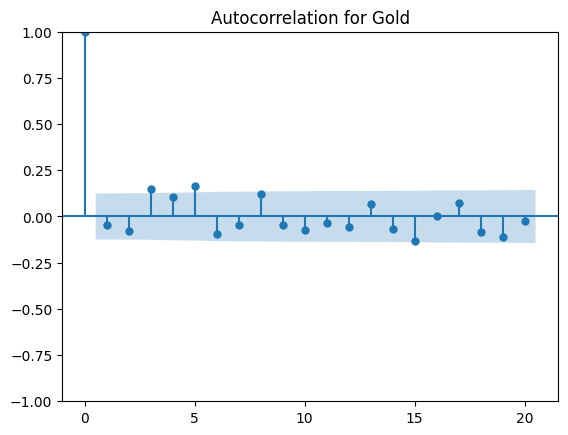

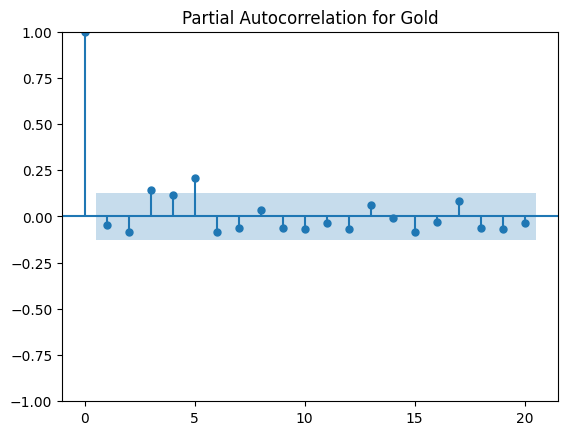

In [43]:
plot_autocorrelograms(diff_data, 'Gold')

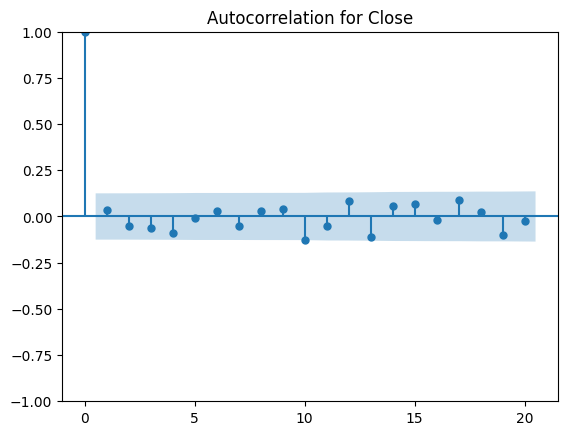

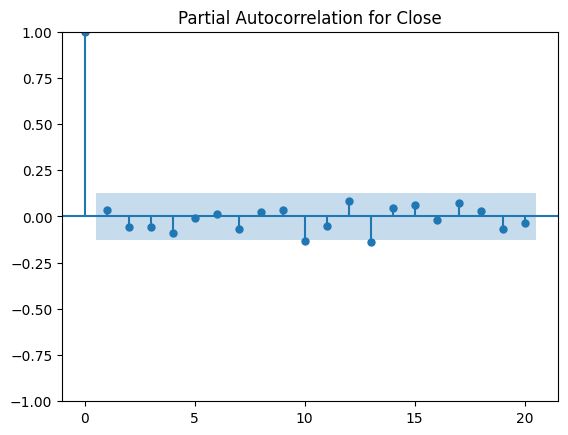

In [44]:
plot_autocorrelograms(diff_data, 'Close')

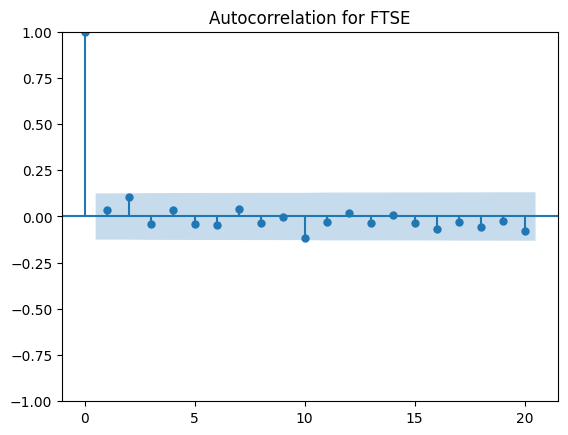

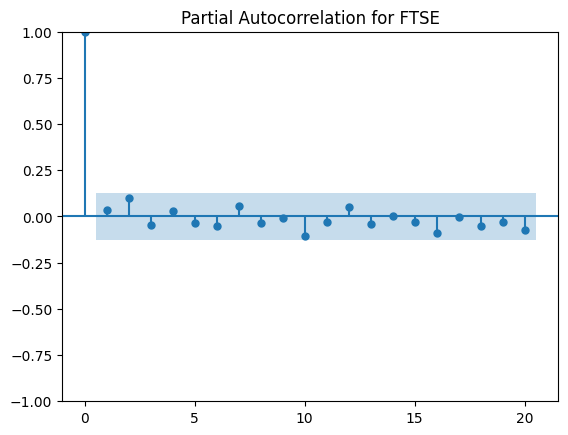

In [45]:
plot_autocorrelograms(diff_data, 'FTSE')

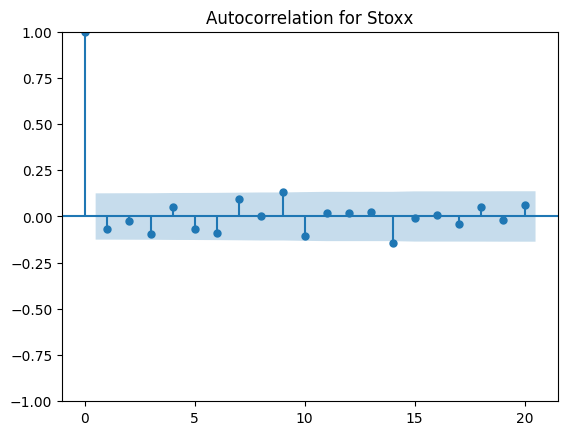

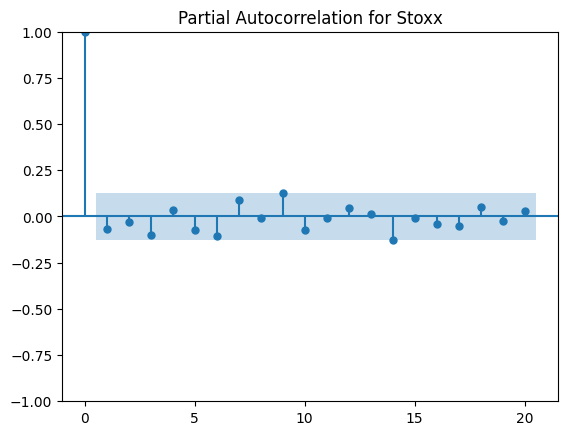

In [46]:
plot_autocorrelograms(diff_data, 'Stoxx')

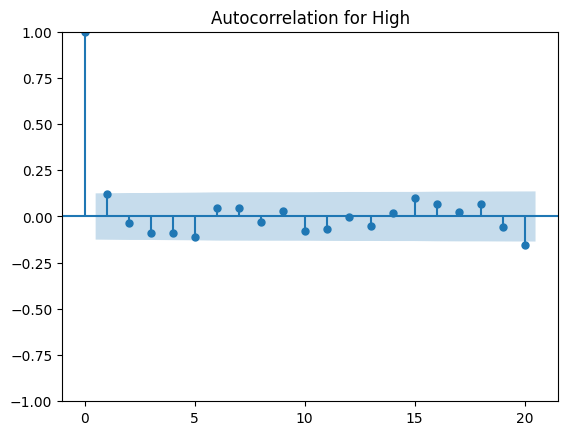

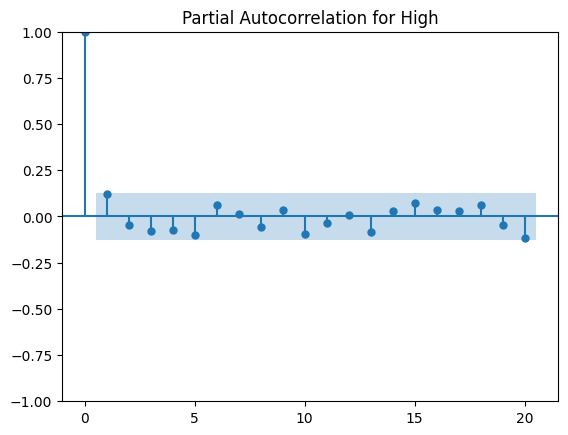

In [47]:
plot_autocorrelograms(diff_data, 'High')

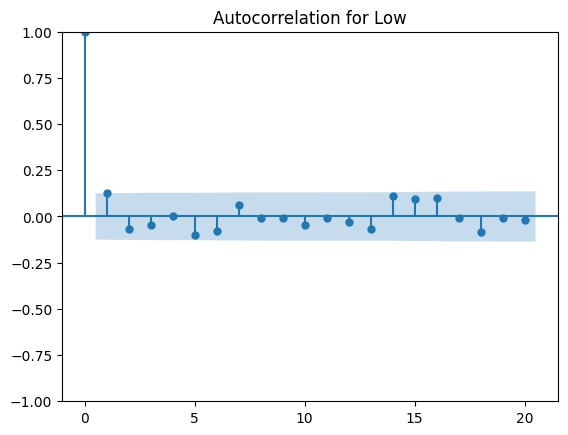

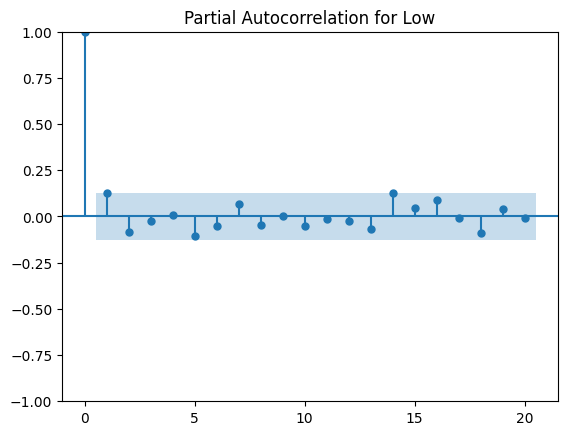

In [48]:
plot_autocorrelograms(diff_data, 'Low')

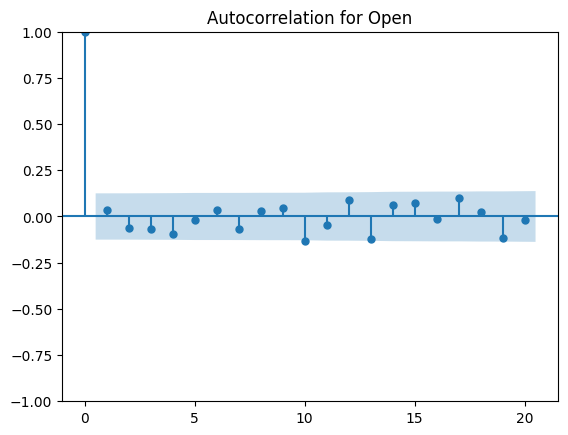

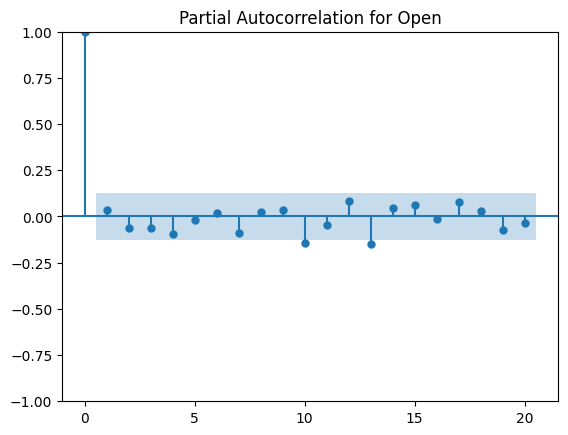

In [49]:
plot_autocorrelograms(diff_data, 'Open')

# Tests #

In [65]:
data = df.copy()
df = data.dropna()

train, test = df[:-5], df[-5:]

data = train

diff_data = diff(data, k_diff=1)
diff_test = diff(df[-6:], k_diff=1)

p = np.arange(1,8)
q = np.arange(1,8)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(endog=diff_data[['Close','Gold', 'Stoxx', 'FTSE']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['Close', 'High', 'Open', 'Low']]).reset_index(drop=True).Close)
        pred['observed'] = test.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))


In [66]:
idx = np.argmin(MSEs)
print(orders[idx])
model_fit = models[idx]

(1, 7)


Text(0.5, 1.0, 'MSE = 4.156813132709233e-05')

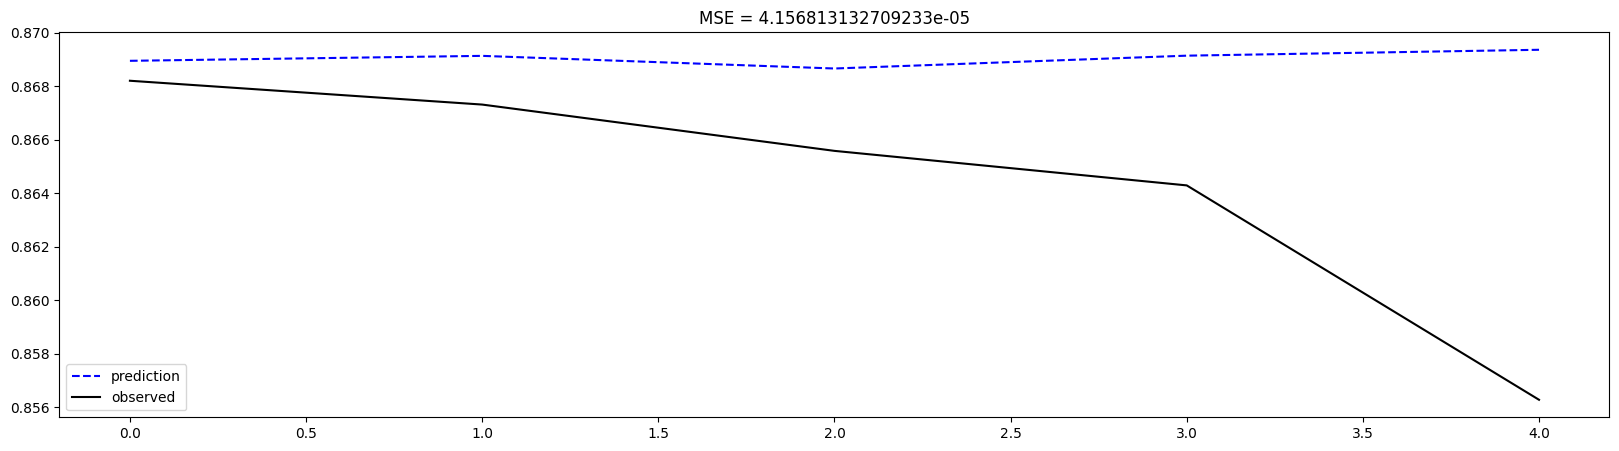

In [69]:
# plot prediction vs observed
pred = pd.DataFrame()
pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['Close', 'High', 'Open', 'Low']]).reset_index(drop=True).Close)
pred['observed'] = test.reset_index(drop=True).Close

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [70]:
print(pred)

   prediction  observed
0    0.868945   0.86820
1    0.869130   0.86731
2    0.868657   0.86558
3    0.869137   0.86429
4    0.869357   0.85628


In [73]:
np.savetxt('predictions_eurgbp.csv', pred['prediction'])
